# Базовое решение задачи

## Импорт

In [1]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torchvision
from torchvision import transforms

In [4]:
# from torchinfo import summary
from tqdm.notebook import tqdm, trange

In [65]:
torch.cuda.device_count()

4

In [66]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))
        if n_devices > 0:
            device = 'cuda:0'
        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn 

In [67]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.1
Using device: cuda
cuda:  cu121
Cuda is available: True
number of devices: 4
Tesla V100-SXM2-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla V100-SXM2-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla V100-SXM2-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Tesla V100-SXM2-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 64


## Загрузка набора данны 

In [68]:
from torchvision.datasets.utils import download_and_extract_archive

In [69]:
# url = 'https://github.com/MVRonkin/Deep-Learning-Foundation-Course/raw/main/2024Light/ContestDataset.zip'
# root_directory = os.path.join(os.getcwd(),'.')
# download_and_extract_archive(url, root_directory)

Созададим базовый набор преобразований для полносвязной сети. Удобно будет пользоваться одноканальными иозбражениями в градации серого.

In [70]:
SIZE = (32,32)
transform_ = lambda x: x.flatten()/255

transform = transforms.Compose([
    transforms.Resize(size=SIZE),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transform_,])

Проверим содержание директории с данными. Содержение представляет собой:
* `train` - директория с тренировочным набором данных;
* `train.csv` - файл с описанием данных в формате `csv`;
* `test` - директория с описанием закрытого тестового набора данных, результаты котрого будут оценены в соревновании;
* `test.csv` - файл с описанием закрытого набора данных в формате `csv`;
* `test_open` - директория с описанием открытого тестового набора данных, для самопроверки;
* `test_open.csv` - файл с описанием открытого набора данных в формате `csv`;

Файлы с открытам описанием данных представляют собой два столбца, сопоставляющих название файла и его метку. В закрытом наборе данных описание - это заданный порядок названий файлов без меток.

In [71]:
path2data = 'ContestDataset'
os.listdir(path2data)

['train.csv',
 'test_open',
 'test',
 'test_open.csv',
 'train',
 '.ipynb_checkpoints',
 'test.csv']

Дополнительно откроем каджый файл описания, чтобы убедиться что он имеет верный формат.

In [72]:
csv = pd.read_csv(os.path.join(path2data,'train.csv'))
csv.head(1)

,file_name,class
0,n03365231_2651.png,airplane


In [73]:
csv = pd.read_csv(os.path.join(path2data,'test_open.csv'))
csv.head(1)

,file_name,class
0,n04308397_5230.png,airplane


In [74]:
csv = pd.read_csv(os.path.join('ContestDataset','test.csv'))
csv.shape

(2424, 1)

Можно заметить, что классы заданы их именами. Нам потребуется присвоить классам численные метки.

In [75]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
csv = pd.read_csv(os.path.join('ContestDataset','test_open.csv'))
print(np.unique(le.fit_transform(csv['class'])), csv['class'].unique() )

[0 1 2 3 4] ['airplane' 'automobile' 'bird' 'cat' 'deer']


In [76]:
le.inverse_transform(np.array((2,)))[0]

'bird'

Теперь создадим класс для работы с данными. Класс представляет собой типичный `Dataset class` `PyTorch`.

Аргументы конструктора:
* `image_dir` - путь к директории c изображениями;
* `data_path` - путь к файлу с описанием изорбажений;
* `transform` - набор преобразований изображения в формате `torchvision.transforms`;
* `le` - заданный энкодер меток (Отметим, что тут мог бы быть более общий класс `target_transform`.

Наиболее важной частью класса является метод `__getitem__`, позволяющий работать с экземплярами класса как со списком, обращаясь по индексу.  

Метод возвращает пару `(x,y)`, где `x` - изображение, а `y` или метка, или название файла, если метки нет.

In [77]:
class ContestDataset(Dataset):
    def __init__(self, image_dir = 'train', data_path = 'train.csv', transform=None, le = False):
        
        self.image_dir = image_dir
        
        csv = pd.read_csv(data_path)      
        
        self.fnames = csv['file_name']        

        self.transform = transform
        
        self.le = le
        
        if 'class' in csv.columns:
            if self.le == False:
                self.le = LabelEncoder()
                self.le.fit(csv['class'])
                
            self.class_names = list(csv['class'].unique())                            
            self.labels = self.le.transform(csv['class'])
            self.labels_exist = True

        else:
            self.labels = None
            self.labels_exist = False

    
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.image_dir,self.fnames[idx]) ) 
#         img = np.asarray(img, dtype=float) 

        if self.transform:
            img = self.transform(img)
        
        if self.labels_exist:
            label = self.labels[idx] 
        else:
            label = self.fnames[idx]

        return img, label

5000
torch.Size([1024]) 0


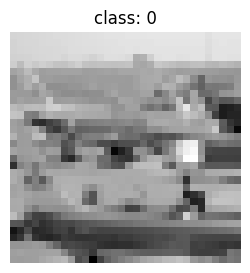

In [78]:
train_data =  ContestDataset(image_dir = os.path.join('ContestDataset','train'), 
                             data_path = os.path.join('ContestDataset','train.csv'),                              
                             transform=transform, le = le)
print(len(train_data))
x,y = train_data[8]
print(x.shape, y)
plt.figure(figsize=(3,3));plt.imshow(x.reshape(*SIZE), cmap='gray'); plt.title('class: '+str(y)); plt.axis('off'); plt.show();

2500
torch.Size([1024])


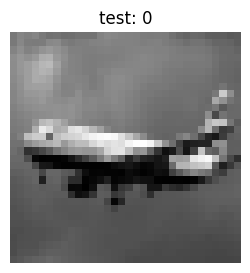

In [79]:
test_data =  ContestDataset(image_dir = os.path.join('ContestDataset','test_open'), 
                            data_path = os.path.join('ContestDataset','test_open.csv'), 
                            transform=transform, le = le)

print(len(test_data))
x,y = test_data[8]
print(x.shape)
plt.figure(figsize=(3,3));plt.imshow(x.reshape(*SIZE), cmap='gray'); plt.title('test: '+str(y)); plt.axis('off'); plt.show();

2424
torch.Size([1024])


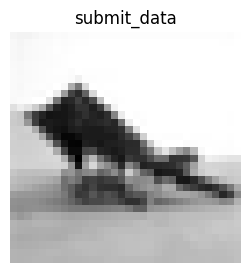

In [80]:
submit_data =  ContestDataset(image_dir = os.path.join('ContestDataset','test'), 
                              data_path = os.path.join('ContestDataset','test.csv'), 
                              transform=transform, le = le)

print(len(submit_data))
x, _ = submit_data[8]
print(x.shape)
plt.figure(figsize=(3,3));plt.imshow(x.reshape(*SIZE), cmap='gray'); plt.title('submit_data'); plt.axis('off'); plt.show();

TRAIN 5000 shape torch.Size([1024])
SUBMIT 2424 shape torch.Size([1024])


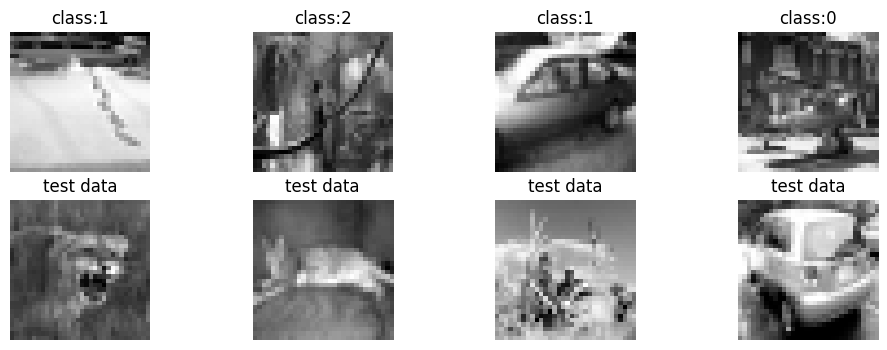

In [81]:
fig, axs = plt.subplots(2,4, figsize=(12,4));

x,y = train_data[0]

print('TRAIN', len(train_data), 'shape', x.shape)
for i,idx in enumerate(np.random.randint(0, len(train_data), 4)):  
    x,y = train_data[idx]    
    axs[0,i].imshow(x.reshape(*SIZE), cmap='gray'); 
    axs[0,i].axis('off'); 
    axs[0,i].set_title('class:'+str(y)); 

x, _ = submit_data[0]
print('SUBMIT', len(submit_data), 'shape', x.shape)
for i,idx in enumerate(np.random.randint(0, len(submit_data), 4)):  
    x, _ = submit_data[idx]    
    axs[1,i].imshow(x.reshape(*SIZE), cmap='gray'); 
    axs[1,i].axis('off'); 
    axs[1,i].set_title('test data'); 

plt.show();

In [82]:
g = torch.Generator('cuda')  # ← Always CPU for random_split
g.manual_seed(42)

## Выделение валидационной подвыборки

In [83]:
TRAIN_RATIO = 0.8

n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples], generator=g)

print(f"Training data size : {len(train_data)}, Validation data size : {len(valid_data)}, Test data size : {len(test_data)}")

Training data size : 4000, Validation data size : 1000, Test data size : 2500


## Создание загрузчика данных

Обратите внимание что на текущий момент имеет место 4 набора данных, и соответственно создается 4 загрузчика данных:
* `train_loader` - тренировочные данные;
* `val_loader`   - валидационные данные;
* `test_loader`  - тестовые данные (открытый тест для самопроверки);
* `submit_loader` - тестовые данные для подачи (закрытый тест).

In [104]:
g_loader = torch.Generator(device=device)  # Explicitly set to CPU
g_loader.manual_seed(0)

In [105]:
import torch.utils.data as data

BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE,
                                 generator=g_loader)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE,
                                 generator=g_loader)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE,
                             generator=g_loader)


submit_loader = data.DataLoader(submit_data,
                                batch_size=BATCH_SIZE,
                               generator=g_loader)
 
print(f"Training data batches : {len(train_loader)}, Validation data batches : {len(val_loader)}, Test data batches : {len(test_loader)}, Submit data batches : {len(test_loader)}")

Training data batches : 63, Validation data batches : 16, Test data batches : 40, Submit data batches : 40


In [106]:
images, label =  next(iter(val_loader))
images.shape, label.shape


(torch.Size([64, 1024]), torch.Size([64]))

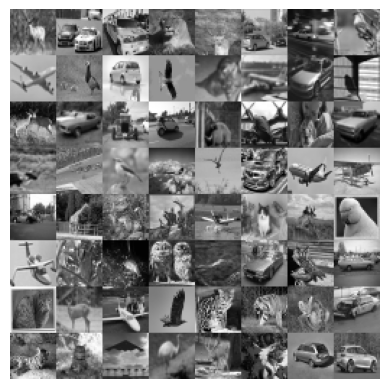

(torch.Size([64, 1, 32, 32]), torch.Size([3, 256, 256]), (256, 256, 3))

In [107]:
images = images.reshape(-1,1,*SIZE)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape

## Создание модели

В данном случае создадим базовую модель - ее результаты нужно исключительно для того, чтобы понять, что набор данных позволяет обучить какую то нейронную сеть и понять какие оценки точности могут считать минимально-достижимыми.

In [163]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(SIZE[0]*SIZE[1], 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc_out = nn.Linear(128, 11)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x)+ x) 
        x = self.fc_out(x)
        return x
        

In [164]:
model = Model()

# summary(model,input_size =(1,SIZE[0]*SIZE[1]))

## Функции для обучения

Функции описывают минимальный рабочий вариант обучения и проверки качества работы нейронной сети.

In [165]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device).float(), y.to(device).long()

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device).float(), y.to(device).long()

            y_pred = model.forward(x)
            
            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

EPOCHS = 100

def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = EPOCHS, device='cpu',  path_best = 'best_model.pt', verbose = True):

   
    best_valid_loss = float('inf')

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose == True:
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
            f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%') 


## Инициализация и обучение модели

Параметры специально не подбирались.

В качестве метрики используется `accuracy` - так как в закрытом наборе качество работы будет также оцениваться по этой метрике.

In [166]:
device

'cuda:0'

In [151]:
model = Model()
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr = 5e-3)


def calculate_accuracy(y_pred, y):
    with torch.no_grad():
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]
    return acc

metric = calculate_accuracy

In [152]:
fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 100, device=device, verbose = True)

  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 2.306 | Train Acc: 20.49%  | Val. Loss: 2.292 | Val. Acc: 19.51%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 2.272 | Train Acc: 23.49%  | Val. Loss: 2.242 | Val. Acc: 26.13%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 2.250 | Train Acc: 26.74%  | Val. Loss: 2.234 | Val. Acc: 29.79%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 2.242 | Train Acc: 27.90%  | Val. Loss: 2.240 | Val. Acc: 28.52%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 2.238 | Train Acc: 28.62%  | Val. Loss: 2.245 | Val. Acc: 26.39%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 2.241 | Train Acc: 27.93%  | Val. Loss: 2.253 | Val. Acc: 27.81%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 2.236 | Train Acc: 28.55%  | Val. Loss: 2.234 | Val. Acc: 30.47%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 2.236 | Train Acc: 28.03%  | Val. Loss: 2.276 | Val. Acc: 24.86%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 2.233 | Train Acc: 29.19%  | Val. Loss: 2.236 | Val. Acc: 29.86%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 2.237 | Train Acc: 28.52%  | Val. Loss: 2.239 | Val. Acc: 29.00%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 2.237 | Train Acc: 28.99%  | Val. Loss: 2.272 | Val. Acc: 24.86%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 1s
	Train Loss: 2.232 | Train Acc: 28.87%  | Val. Loss: 2.233 | Val. Acc: 29.39%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 1s
	Train Loss: 2.234 | Train Acc: 28.89%  | Val. Loss: 2.245 | Val. Acc: 28.46%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 1s
	Train Loss: 2.234 | Train Acc: 28.70%  | Val. Loss: 2.235 | Val. Acc: 30.14%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 2.231 | Train Acc: 29.32%  | Val. Loss: 2.233 | Val. Acc: 29.75%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 1s
	Train Loss: 2.226 | Train Acc: 30.56%  | Val. Loss: 2.233 | Val. Acc: 29.49%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 1s
	Train Loss: 2.228 | Train Acc: 29.79%  | Val. Loss: 2.230 | Val. Acc: 30.06%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 1s
	Train Loss: 2.224 | Train Acc: 30.68%  | Val. Loss: 2.231 | Val. Acc: 29.96%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 1s
	Train Loss: 2.221 | Train Acc: 31.30%  | Val. Loss: 2.240 | Val. Acc: 28.20%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 1s
	Train Loss: 2.224 | Train Acc: 30.75%  | Val. Loss: 2.232 | Val. Acc: 30.29%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 1s
	Train Loss: 2.218 | Train Acc: 31.08%  | Val. Loss: 2.241 | Val. Acc: 27.66%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 1s
	Train Loss: 2.229 | Train Acc: 30.18%  | Val. Loss: 2.238 | Val. Acc: 29.53%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 1s
	Train Loss: 2.217 | Train Acc: 30.65%  | Val. Loss: 2.229 | Val. Acc: 28.98%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 1s
	Train Loss: 2.210 | Train Acc: 32.14%  | Val. Loss: 2.227 | Val. Acc: 30.12%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 1s
	Train Loss: 2.203 | Train Acc: 32.99%  | Val. Loss: 2.223 | Val. Acc: 30.21%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 1s
	Train Loss: 2.201 | Train Acc: 32.84%  | Val. Loss: 2.219 | Val. Acc: 29.79%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 1s
	Train Loss: 2.201 | Train Acc: 33.18%  | Val. Loss: 2.214 | Val. Acc: 30.35%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 1s
	Train Loss: 2.203 | Train Acc: 33.04%  | Val. Loss: 2.208 | Val. Acc: 32.52%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 1s
	Train Loss: 2.200 | Train Acc: 33.28%  | Val. Loss: 2.223 | Val. Acc: 29.36%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 1s
	Train Loss: 2.177 | Train Acc: 36.16%  | Val. Loss: 2.204 | Val. Acc: 32.70%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 1s
	Train Loss: 2.163 | Train Acc: 37.62%  | Val. Loss: 2.195 | Val. Acc: 33.85%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 1s
	Train Loss: 2.166 | Train Acc: 36.86%  | Val. Loss: 2.177 | Val. Acc: 35.63%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 1s
	Train Loss: 2.152 | Train Acc: 38.67%  | Val. Loss: 2.142 | Val. Acc: 39.90%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 1s
	Train Loss: 2.139 | Train Acc: 40.25%  | Val. Loss: 2.132 | Val. Acc: 40.12%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 1s
	Train Loss: 2.153 | Train Acc: 38.47%  | Val. Loss: 2.147 | Val. Acc: 39.32%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 1s
	Train Loss: 2.144 | Train Acc: 39.56%  | Val. Loss: 2.135 | Val. Acc: 40.59%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 1s
	Train Loss: 2.131 | Train Acc: 40.70%  | Val. Loss: 2.130 | Val. Acc: 41.29%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 1s
	Train Loss: 2.125 | Train Acc: 41.34%  | Val. Loss: 2.144 | Val. Acc: 39.51%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 1s
	Train Loss: 2.127 | Train Acc: 41.34%  | Val. Loss: 2.166 | Val. Acc: 37.29%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 1s
	Train Loss: 2.130 | Train Acc: 40.72%  | Val. Loss: 2.142 | Val. Acc: 39.90%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 1s
	Train Loss: 2.119 | Train Acc: 42.24%  | Val. Loss: 2.135 | Val. Acc: 39.92%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 1s
	Train Loss: 2.118 | Train Acc: 42.39%  | Val. Loss: 2.132 | Val. Acc: 40.37%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 1s
	Train Loss: 2.123 | Train Acc: 41.42%  | Val. Loss: 2.122 | Val. Acc: 41.66%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 1s
	Train Loss: 2.131 | Train Acc: 40.40%  | Val. Loss: 2.145 | Val. Acc: 39.22%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 1s
	Train Loss: 2.116 | Train Acc: 42.61%  | Val. Loss: 2.129 | Val. Acc: 41.39%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 1s
	Train Loss: 2.125 | Train Acc: 41.82%  | Val. Loss: 2.138 | Val. Acc: 40.68%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 1s
	Train Loss: 2.121 | Train Acc: 41.77%  | Val. Loss: 2.109 | Val. Acc: 42.99%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 1s
	Train Loss: 2.119 | Train Acc: 41.79%  | Val. Loss: 2.108 | Val. Acc: 43.07%


Training:   0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Тест модели на лучшей эпохе

In [153]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Test Loss: 2.160 | Test Acc: 36.84%


## Создание файла для отправки

Тут созадна специальная отдельная функция `submit` результат работы которой - это `DataFrame` с двумя колноками:
* `file_name`	- название файла из закрытого набора данных
* `class` - предсказанная метка класса (в формате числа от 0 и выше).

In [154]:
def submit(model, dataloader, device):

    df = pd.DataFrame(columns = ('file_name','class'))
    model.eval()

    with torch.inference_mode():
        
        for x,y in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device).float()
            y_pred = model.forward(x)
            if y_pred.is_cuda: 
                cls = list(y_pred.argmax(1, keepdim=False).data.cpu().numpy())
            else:
                cls = list(y_pred.argmax(1, keepdim=False).data.numpy())
            cls_label = le.inverse_transform(np.array((cls)))[0]
            df = pd.concat([df,pd.DataFrame({'file_name':y,'class':cls_label})], ignore_index = True)

    return df.reset_index()

In [155]:
len(submit_data)

2424

In [156]:
df = submit(model, submit_loader, device)

Evaluating:   0%|          | 0/38 [00:00<?, ?it/s]

/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
/tmp/ipykernel_23177/1191959171.py:14: UserWarning: Implicit dimension choice for softmax has been deprec

In [157]:
df

,index,file_name,class
0,0,cifar10-test-1013.png,automobile
1,1,cifar10-test-1050.png,automobile
2,2,cifar10-test-1054.png,automobile
3,3,cifar10-test-1065.png,automobile
4,4,cifar10-test-1098.png,automobile
...,...,...,...
2419,2419,n04583620_7802.png,airplane
2420,2420,n04583620_7926.png,airplane
2421,2421,n04583620_9403.png,airplane
2422,2422,n04583620_9646.png,airplane


Сохраним результат.

<code style="color:red">__Большая просьба сохранять результат с указанием ФИО !__ </code>

In [158]:
path_submit = 'submit.csv'

df[['file_name','class']].to_csv(path_submit, index = False )
print('FULL PATH:  \n', os.path.join(os.getcwd(), path_submit) )

FULL PATH:  
 /storage/reshetnikov/URFU/Computer-Vision-Course_lec-practice/2025/simple classification/submit.csv


Проверка файла на открытие

In [160]:
frame = pd.read_csv('submit.csv')

In [162]:
frame.groupby('class').count()

,file_name
class,
airplane,696
automobile,704
bird,576
cat,256
deer,192
